<a href="https://colab.research.google.com/github/daiweiworking/BenchmarkDeepLearning/blob/master/CoatingTwoNoises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coating two noises

---





## Faster GPUs

With Colab Pro you have priority access to our fastest GPUs. For example, you may get a T4 or P100 GPU at times when most users of standard Colab receive a slower K80 GPU. You can see what GPU you've been assigned at any time by executing the following cell.

In [11]:
!pip3 install imagecorruptions

     |████████████████████████████████| 2.1 MB 5.1 MB/s 


In order to use a GPU with your notebook, select the Runtime > Change runtime type menu, and then set the hardware accelerator dropdown to GPU.

## More memory

With Colab Pro you have the option to access high-memory VMs when they are available. To set your notebook preference to use a high-memory runtime, select the Runtime > 'Change runtime type' menu, and then select High-RAM in the Runtime shape dropdown.

You can see how much memory you have available at any time by running the following code.


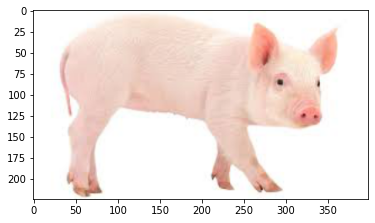

In [13]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# read the image, resize to 224 and convert to PyTorch Tensor
#pig_img = Image.open("GA0.1SP0.15_[7]_1679.jpg")
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

In [15]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();
pred = model(norm(pig_tensor))

In [16]:
#!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

max_class = pred.max(dim=1)[1].item()
print(imagenet_classes[max_class])
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

hog
0.05511913448572159
Predicted probability: 0.946372389793396


In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("pig.jpg")[...,::-1]/255.0
noise =  np.random.normal(loc=0, scale=1, size=img.shape)
noisy2mul = np.clip((img*(1 + noise*0.2)),0,1)



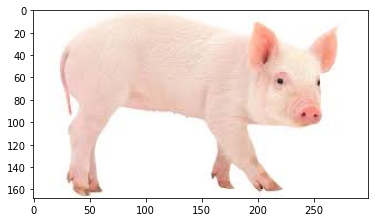

In [30]:
plt.imshow(img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


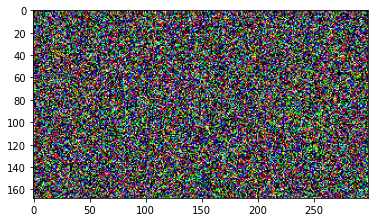

In [41]:

plt.imshow(noise)
#plt.imsave("noise.jpg",noise)


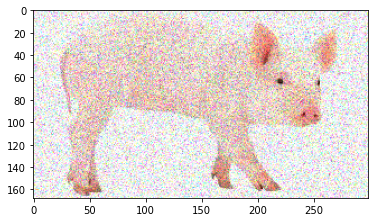

In [38]:

plt.imshow(noisy2mul)
plt.imsave("noiseymul.jpg",noisy2mul)

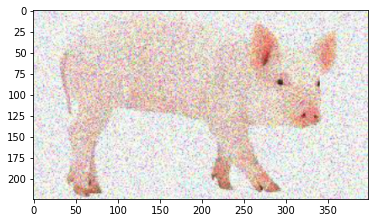

In [43]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img_noise = Image.open("noiseymul.jpg")

preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor_noise = preprocess(pig_img_noise)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor_noise[0].numpy().transpose(1,2,0))

import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

pred = model(norm(pig_tensor_noise))

In [44]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

chow


In [49]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor_noise, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor_noise + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 -2.4499757289886475
5 -24.154510498046875
10 -32.15121078491211
15 -35.48109436035156
20 -31.581947326660156
25 -38.92401123046875
True class probability: 3.083164149333961e-13


In [50]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  chow
Predicted probability: 0.9970705509185791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


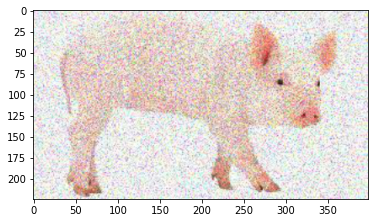

In [52]:
plt.imshow((pig_tensor_noise + delta)[0].detach().numpy().transpose(1,2,0))

In [67]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 15.919832229614258
10 -4.4073076248168945
20 -17.98894500732422
30 -30.60000991821289
40 -40.24546432495117
50 -48.994720458984375
60 -54.67311477661133
70 -59.71725082397461
80 -58.750038146972656
90 -61.65108871459961


In [68]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.9999388456344604


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


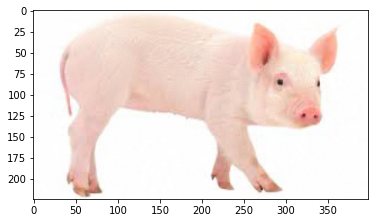

In [70]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

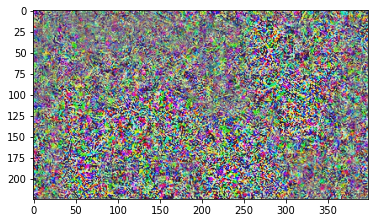

In [57]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). While Colab Pro subscribers still have limits, these will be roughly twice the limits for non-subscribers.

## Resource limits in Colab Pro

Your resources are not unlimited in Colab Pro. To make the most of Colab Pro, please avoid using resources when you don't need them. For example, only use a GPU or high-RAM runtime when required, and close Colab tabs when finished.


## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro and would be interested in a product with higher usage limits, do let us know.

If you encounter errors or other issues with billing (payments) for Colab Pro, please email [colab-billing@google.com](mailto:colab-billing@google.com).